In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"Most recent date: {most_recent_date}")

Most recent date: ('2017-08-23',)


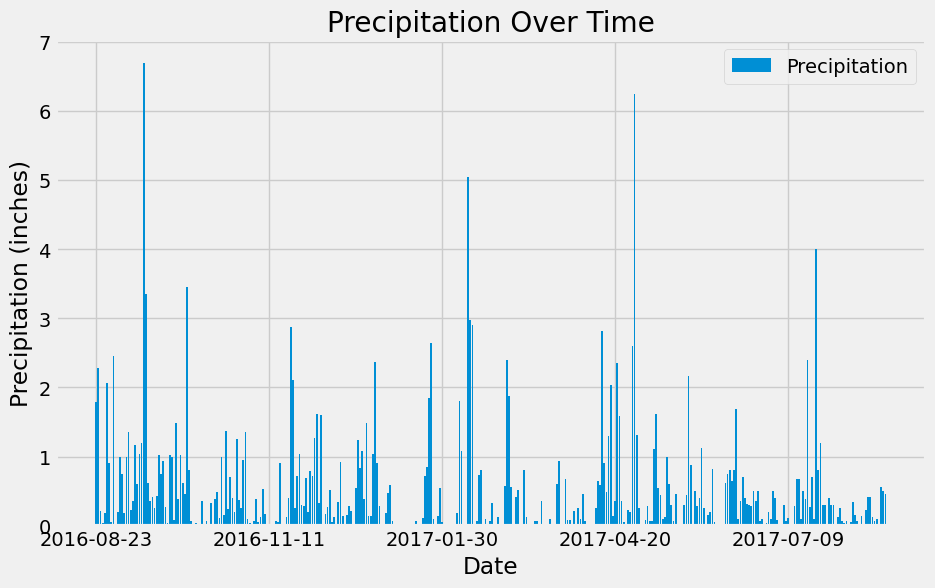

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_from_most_recent_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_from_most_recent_date).all()
last_12_months_precip

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_12_months_precip_df = pd.DataFrame(last_12_months_precip, columns=['Date', 'Precipitation'])
last_12_months_precip_df

# Sort the dataframe by date https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
last_12_months_precip_df.sort_values(by='Date', inplace=True)
last_12_months_precip_df

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(last_12_months_precip_df['Date'], last_12_months_precip_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over Time')

# Make graph look nicer 
# https://stackoverflow.com/questions/34678130/matplotlib-how-can-i-use-maxnlocator-and-specify-a-number-which-has-to-be-in-a
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.legend()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_12_months_precip_df[["Date", "Precipitation"]].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_number_of_stations = session.query(station).group_by(station.station).count()
print(f"Total number of staions: {total_number_of_stations}")

Total number of staions: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session.query(measurement.station, func.count().label('station_count'))
                        .group_by(measurement.station)
                        .order_by(func.count().desc())
                        .all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == "USC00519281").scalar()
most_active_highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == "USC00519281").scalar()
most_active_average_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == "USC00519281").scalar()
print(f"Lowest Temperature: {most_active_lowest_temp}")
print(f"Highest Temperature: {most_active_highest_temp}")
print(f"Average Temperature: {most_active_average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


Text(0.5, 1.0, 'Temperature Distribution Over Last 12 Months')

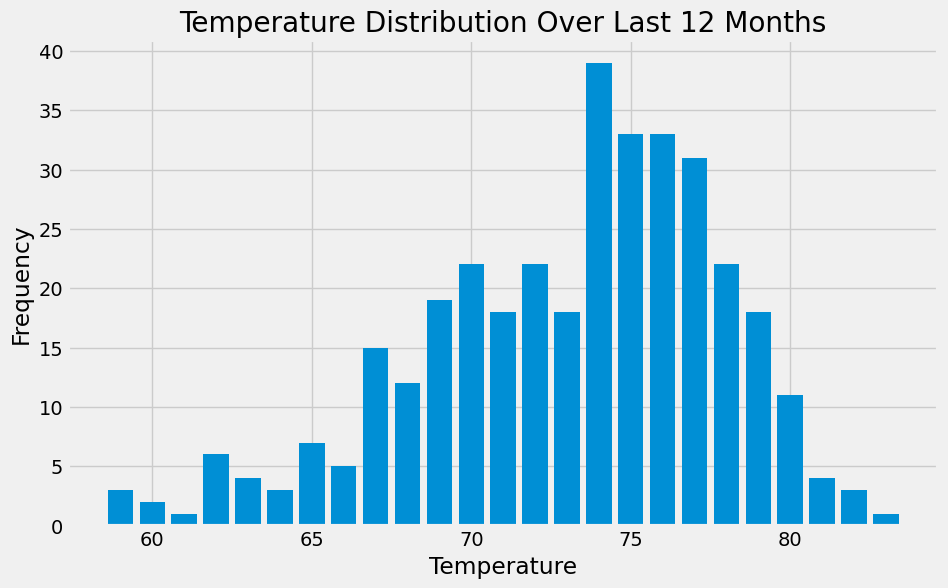

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in data set.
year_from_most_recent_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_temp = (
    session.query(measurement.tobs)
    .filter(measurement.date >= year_from_most_recent_date)
    .filter(measurement.station == "USC00519281")
    .all())
last_12_months_temp

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_12_months_temp_df = pd.DataFrame(last_12_months_temp, columns=['Temp'])
last_12_months_temp_df

# Group by Temp
last_12_months_temp_df_grouped = last_12_months_temp_df.groupby('Temp').size().reset_index(name='Freq')
last_12_months_temp_df_grouped

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.bar(last_12_months_temp_df_grouped['Temp'], last_12_months_temp_df_grouped['Freq'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution Over Last 12 Months')


# Close Session

In [62]:
# Close Session
session.close()